# Deep Learning Starter : Simple LSTM

This notebook leverages the time series structure of the data.

I expect sequential Deep Learning models to dominate in this competition, so here's a simple LSTM architecture.

Parameters were not really tweaked so the baseline is easily improvable.

Code is taken from previous work, some functions are documented but the doc may be outdated.


**Don't fork without upvoting ^^**

In [1]:
!pip install pandas
!pip install numpy
!pip install seaborn matplotlib tqdm


In [2]:
!pip install torch
!pip install scikit-learn

In [3]:
import os
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from collections import Counter

warnings.filterwarnings("ignore")
NUM_WORKERS = 0 #원래 4였음 80에서 pin memory 보고 0으로 변경 

## Data

### Load

In [4]:
DATA_PATH = "/USER/kaggle/ventilator/data/"

sub = pd.read_csv(DATA_PATH + 'sample_submission.csv')
df_train = pd.read_csv(DATA_PATH + 'train.csv')
df_test = pd.read_csv(DATA_PATH + 'test.csv')


df = df_train[df_train['breath_id'] < 5].reset_index(drop=True)

In [5]:
df.head()

,id,breath_id,R,C,time_step,u_in,u_out,pressure
0,1,1,20,50,0.000000,0.083334,0,5.837492
1,2,1,20,50,0.033652,18.383041,0,5.907794
2,3,1,20,50,0.067514,22.509278,0,7.876254
3,4,1,20,50,0.101542,22.808822,0,11.742872
4,5,1,20,50,0.135756,25.355850,0,12.234987


### Viz

In [6]:
def plot_sample(sample_id, df):
    df_breath = df[df['breath_id'] == sample_id]
    r, c  = df_breath[['R', 'C']].values[0]

    cols = ['u_in', 'u_out', 'pressure'] if 'pressure' in df.columns else ['u_in', 'u_out']
    
    plt.figure(figsize=(12, 4))
    for col in ['u_in', 'u_out', 'pressure']:
        plt.plot(df_breath['time_step'], df_breath[col], label=col)
        
    plt.legend()
    plt.title(f'Sample {sample_id} - R={r}, C={c}')

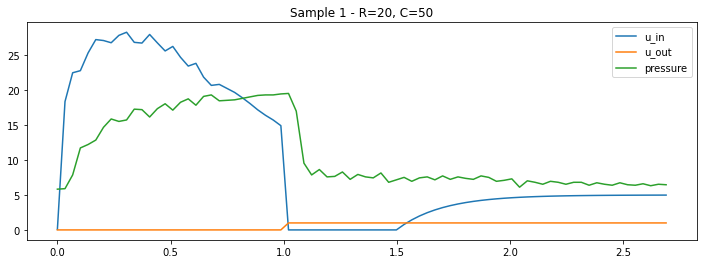

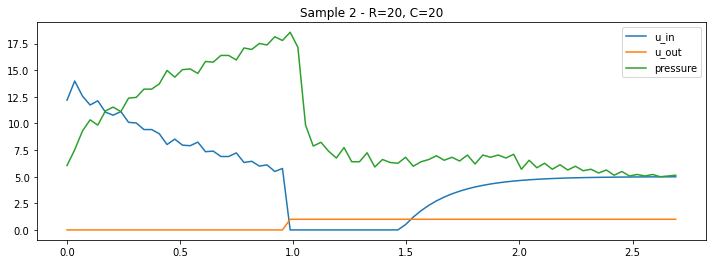

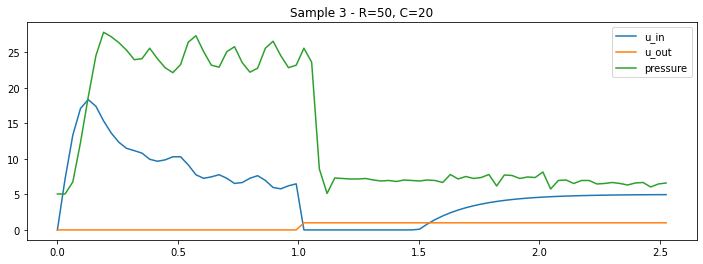

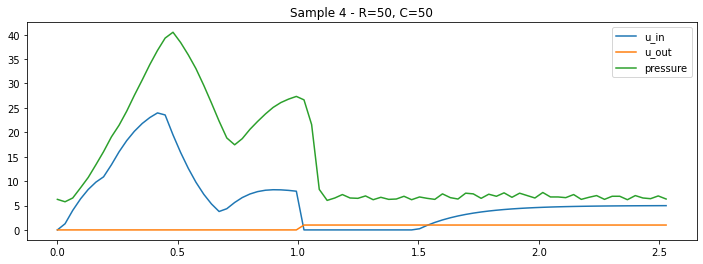

In [7]:
for i in df['breath_id'].unique():
    plot_sample(i, df_train)

### Dataset

In [8]:
import torch
from torch.utils.data import Dataset

class VentilatorDataset(Dataset): # train, test 데이터를 지정하는 것 
    def __init__(self, df):
        if "pressure" not in df.columns:
            df['pressure'] = 0

        self.df = df.groupby('breath_id').agg(list).reset_index()
        
        self.prepare_data()
                
    def __len__(self):
        return self.df.shape[0]
    
    def prepare_data(self):
        self.pressures = np.array(self.df['pressure'].values.tolist())
        
        rs = np.array(self.df['R'].values.tolist())
        cs = np.array(self.df['C'].values.tolist())
        u_ins = np.array(self.df['u_in'].values.tolist())
        
        self.u_outs = np.array(self.df['u_out'].values.tolist())
        
        self.inputs = np.concatenate([
            rs[:, None], 
            cs[:, None], 
            u_ins[:, None], 
            np.cumsum(u_ins, 1)[:, None],
            self.u_outs[:, None]
        ], 1).transpose(0, 2, 1)

    def __getitem__(self, idx):
        data = {
            "input": torch.tensor(self.inputs[idx], dtype=torch.float),
            "u_out": torch.tensor(self.u_outs[idx], dtype=torch.float),
            "p": torch.tensor(self.pressures[idx], dtype=torch.float),
        }
        
        return data

In [9]:
dataset = VentilatorDataset(df)
dataset[0]

{'input': tensor([[2.0000e+01, 5.0000e+01, 8.3334e-02, 8.3334e-02, 0.0000e+00],
         [2.0000e+01, 5.0000e+01, 1.8383e+01, 1.8466e+01, 0.0000e+00],
         [2.0000e+01, 5.0000e+01, 2.2509e+01, 4.0976e+01, 0.0000e+00],
         [2.0000e+01, 5.0000e+01, 2.2809e+01, 6.3784e+01, 0.0000e+00],
         [2.0000e+01, 5.0000e+01, 2.5356e+01, 8.9140e+01, 0.0000e+00],
         [2.0000e+01, 5.0000e+01, 2.7260e+01, 1.1640e+02, 0.0000e+00],
         [2.0000e+01, 5.0000e+01, 2.7127e+01, 1.4353e+02, 0.0000e+00],
         [2.0000e+01, 5.0000e+01, 2.6808e+01, 1.7034e+02, 0.0000e+00],
         [2.0000e+01, 5.0000e+01, 2.7865e+01, 1.9820e+02, 0.0000e+00],
         [2.0000e+01, 5.0000e+01, 2.8313e+01, 2.2651e+02, 0.0000e+00],
         [2.0000e+01, 5.0000e+01, 2.6867e+01, 2.5338e+02, 0.0000e+00],
         [2.0000e+01, 5.0000e+01, 2.6763e+01, 2.8014e+02, 0.0000e+00],
         [2.0000e+01, 5.0000e+01, 2.7993e+01, 3.0814e+02, 0.0000e+00],
         [2.0000e+01, 5.0000e+01, 2.6790e+01, 3.3493e+02, 0.0000e+00

## Model
- 2 Layer MLP -> 5 layers로 변경
- Bidirectional LSTM
- Prediction dense layer

In [10]:
import torch
import torch.nn as nn


class RNNModel(nn.Module):
    def __init__(
        self,
        input_dim=4, # dim 4인 애를 집어 넣어서. 
        lstm_dim=256,
        dense_dim=256,
        logit_dim=256,
        num_classes=1,
    ):
        super().__init__()

        self.mlp = nn.Sequential(
            nn.Linear(input_dim, dense_dim // 2),
            nn.ReLU(),
            # nn.Linear(dense_dim // 2, dense_dim // 2),
            # nn.ReLU(),
            # nn.Linear(dense_dim // 2, dense_dim // 2),
            # nn.ReLU(),
            nn.Linear(dense_dim // 2, dense_dim),
            nn.ReLU(),
        )

        self.lstm = nn.LSTM(dense_dim, lstm_dim, batch_first=True, bidirectional=True)

        self.logits = nn.Sequential(
            nn.Linear(lstm_dim * 2, logit_dim),
            nn.ReLU(),
            nn.Linear(logit_dim, num_classes),
        )

    def forward(self, x):
        features = self.mlp(x)
        features, _ = self.lstm(features)
        pred = self.logits(features)
        return pred

## Training

### Utils

In [11]:
import os
import torch
import random
import numpy as np


def seed_everything(seed):
    """
    Seeds basic parameters for reproductibility of results.

    Args:
        seed (int): Number of the seed.
    """
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
    
def count_parameters(model, all=False):
    """
    Counts the parameters of a model.

    Args:
        model (torch model): Model to count the parameters of.
        all (bool, optional):  Whether to count not trainable parameters. Defaults to False.

    Returns:
        int: Number of parameters.
    """
    if all:
        return sum(p.numel() for p in model.parameters())
    else:
        return sum(p.numel() for p in model.parameters() if p.requires_grad)

    
def worker_init_fn(worker_id):
    """
    Handles PyTorch x Numpy seeding issues.

    Args:
        worker_id (int): Id of the worker.
    """
    np.random.seed(np.random.get_state()[1][0] + worker_id)
    

def save_model_weights(model, filename, verbose=1, cp_folder=""):
    """
    Saves the weights of a PyTorch model.

    Args:
        model (torch model): Model to save the weights of.
        filename (str): Name of the checkpoint.
        verbose (int, optional): Whether to display infos. Defaults to 1.
        cp_folder (str, optional): Folder to save to. Defaults to "".
    """
    if verbose:
        print(f"\n -> Saving weights to {os.path.join(cp_folder, filename)}\n")
    torch.save(model.state_dict(), os.path.join(cp_folder, filename))

### Metric & Loss
> The competition will be scored as the mean absolute error between the predicted and actual pressures during the inspiratory phase of each breath. The expiratory phase is not scored.

In [12]:
def compute_metric(df, preds):
    """
    Metric for the problem, as I understood it.
    """
    
    y = np.array(df['pressure'].values.tolist())
    w = 1 - np.array(df['u_out'].values.tolist())
    
    assert y.shape == preds.shape and w.shape == y.shape, (y.shape, preds.shape, w.shape)
    
    mae = w * np.abs(y - preds)
    mae = mae.sum() / w.sum()
    print(f'computed mae is {mae}')
    return mae


class VentilatorLoss(nn.Module):
    """
    Directly optimizes the competition metric
    """
    def __call__(self, preds, y, u_out):
        w = 1 - u_out
        mae = w * (y - preds).abs()
        mae = mae.sum(-1) / w.sum(-1)

        return mae

### Fit

In [13]:

!pip install transformers --ignore-installed ruamel.yaml

  Using cached transformers-4.11.3-py3-none-any.whl (2.9 MB)
  Using cached ruamel.yaml-0.17.16-py3-none-any.whl (109 kB)
  Using cached tqdm-4.62.3-py2.py3-none-any.whl (76 kB)
  Using cached PyYAML-6.0-cp38-cp38-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_12_x86_64.manylinux2010_x86_64.whl (701 kB)
  Using cached tokenizers-0.10.3-cp38-cp38-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_12_x86_64.manylinux2010_x86_64.whl (3.3 MB)
  Using cached sacremoses-0.0.46-py3-none-any.whl (895 kB)
  Using cached huggingface_hub-0.0.19-py3-none-any.whl (56 kB)
  Using cached packaging-21.0-py3-none-any.whl (40 kB)
  Using cached numpy-1.21.3-cp38-cp38-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (15.7 MB)
  Using cached filelock-3.3.1-py3-none-any.whl (9.7 kB)
  Using cached regex-2021.10.23-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (764 kB)
  Using cached requests-2.26.0-py2.py3-none-any.whl (62 kB)
  Using cached ruamel.yaml.clib-0.2.6-cp38-cp38-manylinux1_x86_64.w

In [14]:
import gc
import time
import torch
import numpy as np
from torch.utils.data import DataLoader
from transformers import get_linear_schedule_with_warmup


def fit(
    model,
    train_dataset,
    val_dataset,
    loss_name="L1Loss",
    optimizer="Adam",
    epochs=50,
    batch_size=32,
    val_bs=32,
    warmup_prop=0.1,
    lr=1e-3,
    num_classes=1,
    verbose=1,
    first_epoch_eval=0,
    device="cuda"
):
    avg_val_loss = 0.

    # Optimizer
    optimizer = getattr(torch.optim, optimizer)(model.parameters(), lr=lr)

    # Data loaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        drop_last=True,
        num_workers=NUM_WORKERS,
        pin_memory=True,
        worker_init_fn=worker_init_fn
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=val_bs,
        shuffle=False,
        num_workers=NUM_WORKERS,
        pin_memory=True,
    )

    # Loss
#     loss_fct = getattr(torch.nn, loss_name)(reduction="none")
    loss_fct = VentilatorLoss()

    # Scheduler
    num_warmup_steps = int(warmup_prop * epochs * len(train_loader))
    num_training_steps = int(epochs * len(train_loader))
    scheduler = get_linear_schedule_with_warmup(
        optimizer, num_warmup_steps, num_training_steps
    )

    for epoch in range(epochs):
        model.train()
        model.zero_grad()
        start_time = time.time()

        avg_loss = 0
        for data in train_loader: # 매 배치별로 pred 결과 값을 만들고, loss 계산 해서 avg_loss에 누적해주고. 
            pred = model(data['input'].to(device)).squeeze(-1)

            loss = loss_fct(
                pred,
                data['p'].to(device),
                data['u_out'].to(device),
            ).mean()
            loss.backward()
            avg_loss += loss.item() / len(train_loader)

            optimizer.step()
            scheduler.step()

            for param in model.parameters():
                param.grad = None

        model.eval()
        mae, avg_val_loss = 0, 0
        preds = []

        with torch.no_grad():
            for data in val_loader:
                pred = model(data['input'].to(device)).squeeze(-1)

                loss = loss_fct(
                    pred.detach(), 
                    data['p'].to(device),
                    data['u_out'].to(device),
                ).mean()
                avg_val_loss += loss.item() / len(val_loader)

                preds.append(pred.detach().cpu().numpy())
        
        preds = np.concatenate(preds, 0)
        mae = compute_metric(val_dataset.df, preds)

        elapsed_time = time.time() - start_time
        if (epoch + 1) % verbose == 0:
            elapsed_time = elapsed_time * verbose
            lr = scheduler.get_last_lr()[0]
            print(
                f"Epoch {epoch + 1:02d}/{epochs:02d} \t lr={lr:.1e}\t t={elapsed_time:.0f}s \t"
                f"loss={avg_loss:.3f}",
                end="\t",
            )

            if (epoch + 1 >= first_epoch_eval) or (epoch + 1 == epochs):
                print(f"val_loss={avg_val_loss:.3f}\tmae={mae:.3f}")
            else:
                print("")

    del (val_loader, train_loader, loss, data, pred)
    gc.collect()
    torch.cuda.empty_cache()

    return preds


### Predict

In [15]:
def predict(
    model,
    dataset,
    batch_size=64,
    device="cuda"
):# 테스트 데이터를 가지고 평가하는 함수 predict
    """
    Usual torch predict function. Supports sigmoid and softmax activations.
    Args:
        model (torch model): Model to predict with.
        dataset (PathologyDataset): Dataset to predict on.
        batch_size (int, optional): Batch size. Defaults to 64.
        device (str, optional): Device for torch. Defaults to "cuda".

    Returns:
        numpy array [len(dataset) x num_classes]: Predictions.
    """
    model.eval()

    loader = DataLoader(
        dataset, batch_size=batch_size, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True
    )
    
    preds = []
    with torch.no_grad():
        for data in loader:
            pred = model(data['input'].to(device)).squeeze(-1)
            preds.append(pred.detach().cpu().numpy())

    preds = np.concatenate(preds, 0)
    return preds

## Train

In [16]:
def train(config, df_train, df_val, df_test, fold):
    """
    Trains and validate a model.

    Args:
        config (Config): Parameters.
        df_train (pandas dataframe): Training metadata.
        df_val (pandas dataframe): Validation metadata.
        df_test (pandas dataframe): Test metadata.
        fold (int): Selected fold.

    Returns:
        np array: Study validation predictions.
    """

    seed_everything(config.seed)

    model = RNNModel(
        input_dim=config.input_dim,
        lstm_dim=config.lstm_dim,
        dense_dim=config.dense_dim,
        logit_dim=config.logit_dim,
        num_classes=config.num_classes,
    ).to(config.device)
    model.zero_grad()

    train_dataset = VentilatorDataset(df_train)
    val_dataset = VentilatorDataset(df_val)
    test_dataset = VentilatorDataset(df_test)

    n_parameters = count_parameters(model)

    print(f"    -> {len(train_dataset)} training breathes")
    print(f"    -> {len(val_dataset)} validation breathes")
    print(f"    -> {n_parameters} trainable parameters\n")

    pred_val = fit(
        model,
        train_dataset,
        val_dataset,
        loss_name=config.loss,
        optimizer=config.optimizer,
        epochs=config.epochs,
        batch_size=config.batch_size,
        val_bs=config.val_bs,
        lr=config.lr,
        warmup_prop=config.warmup_prop,
        verbose=config.verbose,
        first_epoch_eval=config.first_epoch_eval,
        device=config.device,
    )
    
    pred_test = predict(
        model, 
        test_dataset, 
        batch_size=config.val_bs, 
        device=config.device
    )

    if config.save_weights:
        save_model_weights(
            model,
            f"{config.selected_model}_{fold}.pt",
            cp_folder="",
        )

    del (model, train_dataset, val_dataset, test_dataset)
    gc.collect()
    torch.cuda.empty_cache()

    return pred_val, pred_test

### $k$-fold

In [17]:
from sklearn.model_selection import GroupKFold

def k_fold(config, df, df_test):
    """
    Performs a patient grouped k-fold cross validation.
    """

    pred_oof = np.zeros(len(df))
    preds_test = []
    
    gkf = GroupKFold(n_splits=config.k)
    splits = list(gkf.split(X=df, y=df, groups=df["breath_id"]))

    for i, (train_idx, val_idx) in enumerate(splits):
        if i in config.selected_folds:
            print(f"\n-------------   Fold {i + 1} / {config.k}  -------------\n")

            df_train = df.iloc[train_idx].copy().reset_index(drop=True)
            df_val = df.iloc[val_idx].copy().reset_index(drop=True)

            pred_val, pred_test = train(config, df_train, df_val, df_test, i)
            
            pred_oof[val_idx] = pred_val.flatten()
            preds_test.append(pred_test.flatten())

    print(f'\n -> CV MAE : {compute_metric(df, pred_oof) :.3f}')

    return pred_oof, np.mean(preds_test, 0)

## Main

In [18]:
class Config:
    """
    Parameters used for training
    """
    # General
    seed = 42
    verbose = 1
    device = "cuda" if torch.cuda.is_available() else "cpu"
    save_weights = True

    # k-fold
    k = 2
    selected_folds = [0,1]
    
    # Model
    selected_model = 'rnn'
    input_dim = 5 # 5에서 

    dense_dim = 512
    lstm_dim = 512
    logit_dim = 512
    num_classes = 1

    # Training
    loss = "L1Loss"  # not used
    optimizer = "Adam"
    batch_size = 256 #128에서 수정함
    epochs = 200

    lr = 9.9e-04
    warmup_prop = 0

    val_bs = 256
    first_epoch_eval = 0

In [19]:
torch.cuda.empty_cache() # PyTorch thing

with torch.no_grad():
    torch.cuda.empty_cache()

In [20]:
pred_oof, pred_test = k_fold(
    Config, 
    df_train,
    df_test,
)


-------------   Fold 1 / 2  -------------

    -> 37725 training breathes
    -> 37725 validation breathes
    -> 4860929 trainable parameters

computed mae is 2.2771516376367256
Epoch 01/200 	 lr=9.9e-04	 t=38s 	loss=3.483	val_loss=2.259	mae=2.277
computed mae is 1.7514065110097823
Epoch 02/200 	 lr=9.8e-04	 t=41s 	loss=2.040	val_loss=1.742	mae=1.751
computed mae is 1.5765454431844403
Epoch 03/200 	 lr=9.8e-04	 t=40s 	loss=1.746	val_loss=1.567	mae=1.577
computed mae is 1.7799739683220668
Epoch 04/200 	 lr=9.7e-04	 t=40s 	loss=1.549	val_loss=1.767	mae=1.780
computed mae is 1.3128420203829574
Epoch 05/200 	 lr=9.7e-04	 t=40s 	loss=1.451	val_loss=1.308	mae=1.313
computed mae is 1.2707901520506706
Epoch 06/200 	 lr=9.6e-04	 t=41s 	loss=1.319	val_loss=1.266	mae=1.271
computed mae is 1.259520229677767
Epoch 07/200 	 lr=9.6e-04	 t=40s 	loss=1.269	val_loss=1.254	mae=1.260
computed mae is 1.1801339472844696
Epoch 08/200 	 lr=9.5e-04	 t=40s 	loss=1.234	val_loss=1.175	mae=1.180
computed mae is 

### Predictions

In [21]:
def plot_prediction(sample_id, df):
    df_breath = df[df['breath_id'] == sample_id]

    cols = ['u_in', 'u_out', 'pressure'] if 'pressure' in df.columns else ['u_in', 'u_out']
    
    plt.figure(figsize=(12, 4))
    for col in ['pred', 'pressure', 'u_out']:
        plt.plot(df_breath['time_step'], df_breath[col], label=col)
        
    metric = compute_metric(df_breath, df_breath['pred'])
        
    plt.legend()
    plt.title(f'Sample {sample_id} - MAE={metric:.3f}')

In [22]:
df_train["pred"] = pred_oof

computed mae is 0.27822751319925954
computed mae is 0.6164191636581164
computed mae is 0.4355049377366574
computed mae is 0.9631754257547347
computed mae is 0.1395981402885627


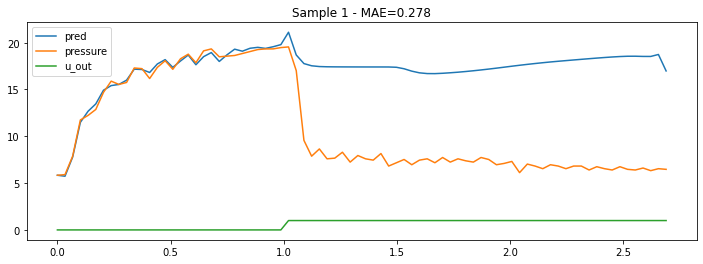

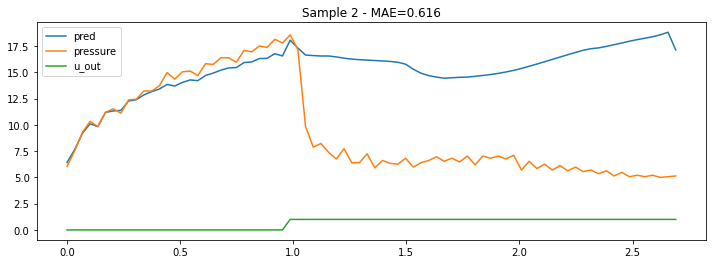

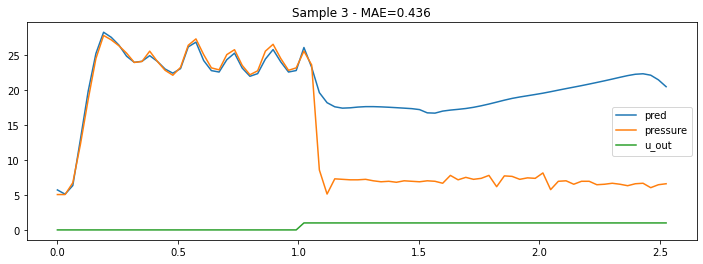

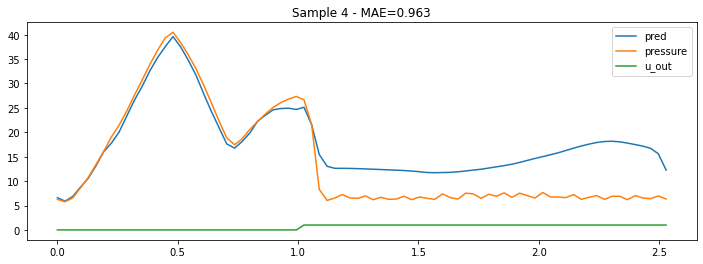

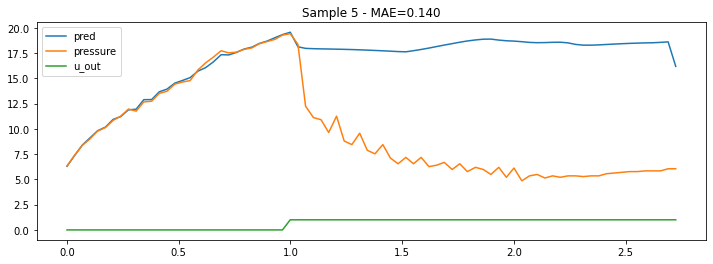

In [23]:
for i in df_train['breath_id'].unique()[:5]:
    plot_prediction(i, df_train)

## Sub

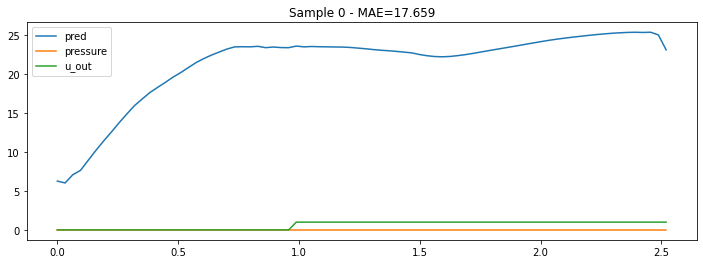

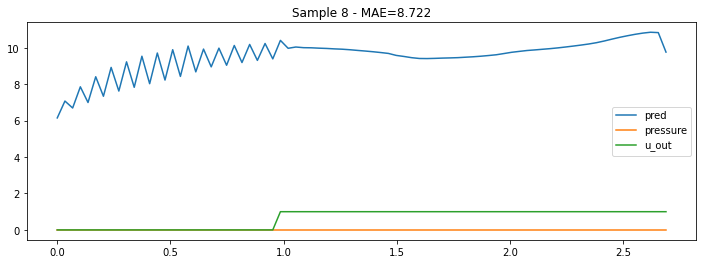

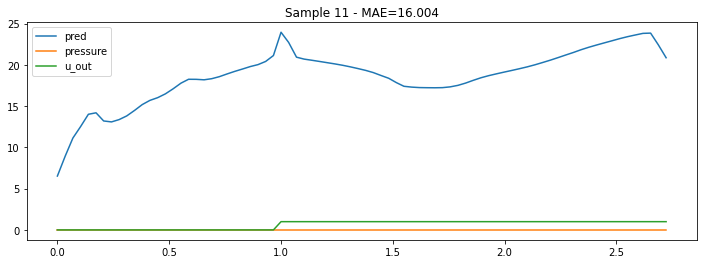

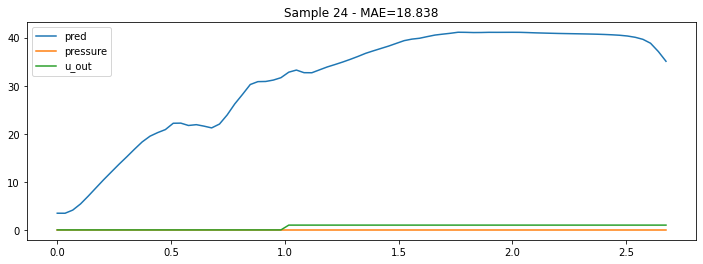

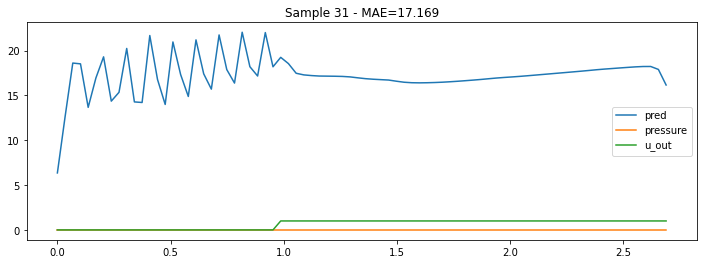

In [25]:
df_test['pred'] = pred_test

for i in df_test['breath_id'].unique()[:5]:
    plot_prediction(i, df_test)

In [26]:
sub['pressure'] = pred_test
sub.to_csv('submission.csv', index=False)

**Thanks for reading !**